# Import packages and set seeds

In [ ]:
#! pip install pyDOE

In [21]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from scipy.interpolate import griddata

import numpy as np
import time
#from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

import copy

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 

cuda


In [22]:
print(f"Device name: {torch.cuda.get_device_name(0)}")
!nvidia-smi

Device name: NVIDIA A100-PCIE-40GB
Fri Feb 24 10:53:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  Off  | 00000000:C3:00.0 Off |                    0 |
| N/A   38C    P0    50W / 250W |   1475MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                     

# Data Preparation
Training and Testing data is prepared from the solution file

In [23]:
data = np.load('final_data.npz') # Load data from file
keys = list(data.keys()) # all keys in the dictionary
print(keys)
nodes3D = data[keys[0]]
temperature = data[keys[1]]
boundary_nodal_coordinates3D = data[keys[2]]
boundary_solution = data[keys[3]]
# face3 = data[keys[4]]
# face4 = data[keys[5]]
# face5 = data[keys[6]]
# face6 = data[keys[7]]
print(np.shape(nodes3D))
print(np.shape(temperature))
print(np.shape(boundary_nodal_coordinates3D))
print(np.shape(boundary_solution))

['nodes', 'temperature', 'boundary_nodal_coordinates', 'boundary_solution']
(5800, 3)
(5800, 1)
(612, 3)
(612, 1)


In [24]:
# cutting the useless third dimension where there is nothing to predict
nodes = nodes3D[:,[0,2]]
#temperature = temperature3D[:,[0,2]]
boundary_nodal_coordinates = boundary_nodal_coordinates3D[:,[0,2]]
#boundary_solution = boundary_solution3D[:,[0,2]]
print(np.shape(nodes))
print(np.shape(temperature))
print(np.shape(boundary_nodal_coordinates))
print(np.shape(boundary_solution))

(5800, 2)
(5800, 1)
(612, 2)
(612, 1)


In [25]:
# Bounds shall be in accordance with nodes[x,y,z]
ub = nodes.max(axis=0)
lb = nodes.min(axis=0)
print(ub)
print(lb)

[0.5 1. ]
[-0.5  0. ]


# Test data
Just for comparing with the PINN predicted solution

In [26]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
#X_u_test = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
#lb = X_u_test[0]  # [-1. 0.]
#ub = X_u_test[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
#u_true = usol.flatten('F')[:,None] 
X_u_test = nodes
u_true = temperature

# Training data

In [27]:
def trainingdata(N_u,N_f):

    '''Boundary Conditions'''

#     #Initial Condition -1 =< x =<1 and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]

#     #Boundary Condition x = -1 and 0 =< t =<1
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[-1,:][:,None]

#     #Boundary Condition x = 1 and 0 =< t =<1
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[0,:][:,None]

#     all_X_u_train = np.vstack([leftedge_x, bottomedge_x, topedge_x]) # X_u_train [456,2] (456 = 256(L1)+100(L2)+100(L3))
#     all_u_train = np.vstack([leftedge_u, bottomedge_u, topedge_u])   #corresponding u [456x1]
    
    all_X_u_train = boundary_nodal_coordinates # all nodal coordinates
    all_u_train = boundary_solution # boundary condition solution
    #choose random N_u points for training
    # all_X_u_train.shape[0] = 34071
    #idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) 

   # X_u_train = all_X_u_train[idx, :] #choose indices from  set 'idx' (x,t)
    #u_train = all_u_train[idx,:]      #choose corresponding u
    X_u_train = all_X_u_train
    u_train = all_u_train 
    
    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
   # X_f_train = lb + (ub-lb)*lhs(2,N_f) 
    #X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    # No Latin Hypercube sampling. Just put all the data
    
    X_f_train = nodes # nodal coordinates or collocation points
    return X_f_train, X_u_train, u_train 


# Physics-informed neural network 

In [403]:
class Sequentialmodel(nn.Module):
    def __init__(self, layers):
        super().__init__() #call __init__ from parent class to initialise the torch.nn.Module
              
        # Activation function
        self.activation = nn.Tanh()
        
        # Loss function
        # reduction = none returns the pointwise squared loss :  (y-y_hat)^2 
        # https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html
        self.loss_function = nn.MSELoss(reduction ='none')
        
        # Initialise neural network as a list using nn.Modulelist 
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        self.iter = 0 # Initialise iteration variable
        
        #
        # Alternatively:
        
        #*all layers are callable 
    
        #Simple linear Layers
        #self.fc1 = nn.Linear(2,50)
        #self.fc2 = nn.Linear(50,50)
        #self.fc3 = nn.Linear(50,50)
        #self.fc4 = nn.Linear(50,1)
        
        
        # Xavier Normal Initialization
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            
            # weights from a normal distribution with 
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
    def forward(self,x):
        # Forward pass
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
                        
             
        #Alternatively:
        
        #a = self.activation(self.fc1(a))
        #a = self.activation(self.fc2(a))
        #a = self.activation(self.fc3(a))
        #a = self.fc4(a)
        
        for i in range(len(layers)-2): # last layer is not activated
            
            z = self.linears[i](a)
                        
            a = self.activation(z)
            
        a = self.linears[-1](a) # linear feedforward no activation (y= mx+c)
        
        return a
        
    def loss_BC(self,x,y):
        # Boundary condition loss 
        # Splitting the forward pass and loss computation to visualise the pointwise loss
        x.requires_grad = True  # Set requires_grad=True for x
        
        forwarded_BC = self.forward(x)
        loss_u = self.loss_function(forwarded_BC,y)

        
        # gradient of the BC loss
        BC_pointwise_x_y = autograd.grad(loss_u,x,torch.ones([loss_u.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        BC_pointwise_x = BC_pointwise_x_y [:,[0]]
        BC_pointwise_y = BC_pointwise_x_y [:,[1]]
        
        return loss_u, BC_pointwise_x, BC_pointwise_y

    def loss_PDE(self, x_to_train_f):
        
        #nu = 0.01/np.pi
        #k = 0.01  # thermal conductivity
        #
        # 3D heat conduction with constant k and no heat generation term
        # We don't need k
        # T_xx + T_yy + T_zz = 0
        # This is also known as the Laplace equation
        
        #x_1_f = x_to_train_f[:,[0]]
        #x_2_f = x_to_train_f[:,[1]]
                        
        g = x_to_train_f.clone()
                        
        g.requires_grad = True
        
        u = self.forward(g)
                
        #u_x_t = autograd.grad(u,g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
                                
        #u_xx_tt = autograd.grad(u_x_t,g,torch.ones(x_to_train_f.shape).to(device), create_graph=True)[0]
                                                            
        #u_x = u_x_t[:,[0]]
        
        #u_t = u_x_t[:,[1]]
        
        #u_xx = u_xx_tt[:,[0]]
        # This is 2D problem
        # First derivative of u w.r.t to all inputs i.e. x, y and z
        u_x_y = autograd.grad(u,g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        # Second derivative of u w.r.t to all inputs i.e. x, y and z                        
        u_xx_yy = autograd.grad(u_x_y,g,torch.ones(x_to_train_f.shape).to(device), create_graph=True)[0]
        # Since there are 3 input vectors x,y and z                                                    
        u_xx = u_xx_yy[:,[0]]
        
        u_yy = u_xx_yy[:,[1]]
        
        #u_zz = u_xx_yy_zz[:,[2]]
                                        
        #f = u_t + (self.forward(g))*(u_x) - (nu)*u_xx 
        
        #loss_f = self.loss_function(f,f_hat)
        # PDE loss                                
        f = u_xx + u_yy #+ u_zz      
        loss_f = self.loss_function(f,f_hat) # f_hat is global variable in the main section
            
        # gradient of the PDE loss
        PDE_pointwise_x_y = autograd.grad(loss_f,g,torch.ones([loss_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        PDE_pointwise_x = PDE_pointwise_x_y [:,[0]]
        PDE_pointwise_y = PDE_pointwise_x_y [:,[1]]
        
        return loss_f, u_xx, u_yy, PDE_pointwise_x, PDE_pointwise_y
    
    def loss(self,x,y,x_to_train_f):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(x_to_train_f)
        
        loss_val = loss_u + loss_f
        
        return loss_val
     
    'callable for optimizer'                                       
    def closure(self):
        
        optimizer.zero_grad()
        
        loss = self.loss(X_u_train, u_train, X_f_train)
        
        loss.backward()
                
        self.iter += 1
        
        if self.iter % 100 == 0:

            error_vec, _ = PINN.test()
        
            print(loss,error_vec)

        return loss        
    
    'test neural network'
    def test(self):
                
        u_pred = self.forward(X_u_test_tensor)
        
        error_vec = torch.linalg.norm((u-u_pred),2)/torch.linalg.norm(u,2)        # Relative L2 Norm of the error (Vector)
        
        u_pred = u_pred.cpu().detach().numpy()
        
        #u_pred = np.reshape(u_pred,(256,100),order='F')
                
        return error_vec, u_pred
        
        
        
        

# Main

In [419]:
 
N_u = 100 #Total number of data points for 'u'
N_f = 10_000 #Total number of collocation points 
X_f_train_np_array, X_u_train_np_array, u_train_np_array = trainingdata(N_u,N_f)

# Convert numpy arrays to tensors 
X_f_train = torch.from_numpy(X_f_train_np_array).float().to(device)
X_u_train = torch.from_numpy(X_u_train_np_array).float().to(device)
u_train = torch.from_numpy(u_train_np_array).float().to(device)
X_u_test_tensor = torch.from_numpy(X_u_test).float().to(device)
u = torch.from_numpy(u_true).float().to(device)
f_hat = torch.zeros(X_f_train.shape[0],1).to(device)

layers = np.array([2,20,20,20,20,1]) # Units in hidden layers
#layers = np.array([3,50,50,50,50,1]) 
#layers = np.array([3,100,100,100,100,1]) 

PINN = Sequentialmodel(layers)
bestPINN = Sequentialmodel(layers) # this is our model with lowest training because PINNs don't have validation but testing error
# We do not need to assign this to a device as we will not train the bestPINN model.
PINN.to(device)
bestPINN.to(device)

params = list(PINN.parameters())

# Optimisation

optimizer = optim.Adam(PINN.parameters(), lr=0.001,betas=(0.8, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

max_iter = 1500

start_time = time.time()
BC_loss_array = np.zeros(max_iter)
PDE_loss_array = np.zeros(max_iter)
total_loss_array = np.zeros(max_iter)
test_error_array = np.zeros(max_iter)
#flag = np.zeros(max_iter,dtype=bool)

for i in range(max_iter):
    #eps1 = 10
    #eps2 = 0.1
    
    # calculate the pde loss first as we need the divergence to apply pointwise weighting
    
    PDE_loss_pointwise, u_xx, u_yy, L_x, L_y = PINN.loss_PDE(X_f_train) # PDE loss
    PDE_loss = PDE_loss_pointwise.mean()
    PDE_coeff = 1#/(abs((u_xx + u_yy).mean()) -0)# ((u_xx + u_yy).mean()))
    
    
    BC_loss_pointwise, L_x_BC, L_y_BC =  PINN.loss_BC(X_u_train, u_train) # BC loss
    BC_loss = BC_loss_pointwise.mean()
    #u_xx_BC, u_yy_BC = PINN.loss_PDE(X_u_train, BC=True)
    BC_coeff = 1
    
    total_loss = BC_coeff * BC_loss + PDE_coeff * PDE_loss #+ 1 * torch.norm(PINN.state_dict()['linears.0.weight']) # add L2 regularization term
    
    optimizer.zero_grad()     # zeroes the gradient in each epoch
    
    total_loss.backward() # backprop the total loss and store in .grad()
    
    optimizer.step() # update parameters
    
    error_vec, _ = PINN.test() # save time by not predicting the u_pred in each iteration
    BC_loss_array [i] = BC_loss
    PDE_loss_array[i] = PDE_loss
    total_loss_array[i] = total_loss  
    test_error_array[i] = error_vec
    
    
    if i % (max_iter/100) == 0:
        print(f" Epoch: {i+1} \t BC Loss: {BC_loss:0.4f}\t PDE Loss: {PDE_loss:0.4f} \t Loss: {total_loss:0.4f} \t Test Error: {error_vec:0.4f}")
    if total_loss < 1e-3:
        print(f'Loss converged in {i} Epochs')
        break
        
    # Choosing the best model
    
    if i>=2 and test_error_array[i] < np.amin(test_error_array[0:(i-1)]): # if current total loss is the minimum in the test loss array for all previous iterations i.e. [0,i-1]
        # for i<2, in test_error_array[0:(i-1)] is i-1 is negative (i=0) and null (i=1), so better avoid first two iteration for selecting the best model
        #flag[i] = True
        #print(f'Best model found at {i} th iteration with test error = {error_vec:0.4f}')
        bestPINN.load_state_dict(copy.deepcopy(PINN.state_dict())) # then the current PINN model is the best model, copying the state dictionary to the bestPINN
        # https://discuss.pytorch.org/t/copy-deepcopy-vs-clone/55022
        best_iter = i # save the best iteration to put it on the test error plot
    #else:
    #    flag[i]=False
#     if i % (max_iter/10) == 0:
#         error_vec, _ = PINN.test()
#         print(loss,error_vec)

else:
    print('Training finished')
    elapsed = time.time() - start_time                
    print('Training time: %.2f' % (elapsed))
    print(f"Final loss: {total_loss}")




''' Model Accuracy ''' 
best_error_vec, best_u_pred = bestPINN.test() # use the best model to evaluate the test error
final_error_vec, final_u_pred = PINN.test()
print('Best Test Error: %.5f'  % (best_error_vec))
print('Final Test Error: %.5f'  % (final_error_vec))

 Epoch: 1 	 BC Loss: 0.5894	 PDE Loss: 0.0258 	 Loss: 0.6152 	 Test Error: 0.9749
 Epoch: 16 	 BC Loss: 0.2728	 PDE Loss: 0.0075 	 Loss: 0.2803 	 Test Error: 0.5503
 Epoch: 31 	 BC Loss: 0.2520	 PDE Loss: 0.0006 	 Loss: 0.2526 	 Test Error: 0.5040
 Epoch: 46 	 BC Loss: 0.2492	 PDE Loss: 0.0006 	 Loss: 0.2498 	 Test Error: 0.5004
 Epoch: 61 	 BC Loss: 0.2466	 PDE Loss: 0.0006 	 Loss: 0.2472 	 Test Error: 0.4970
 Epoch: 76 	 BC Loss: 0.2436	 PDE Loss: 0.0010 	 Loss: 0.2445 	 Test Error: 0.4930
 Epoch: 91 	 BC Loss: 0.2396	 PDE Loss: 0.0016 	 Loss: 0.2413 	 Test Error: 0.4879
 Epoch: 106 	 BC Loss: 0.2346	 PDE Loss: 0.0028 	 Loss: 0.2374 	 Test Error: 0.4813
 Epoch: 121 	 BC Loss: 0.2288	 PDE Loss: 0.0046 	 Loss: 0.2334 	 Test Error: 0.4737
 Epoch: 136 	 BC Loss: 0.2230	 PDE Loss: 0.0064 	 Loss: 0.2294 	 Test Error: 0.4661
 Epoch: 151 	 BC Loss: 0.2174	 PDE Loss: 0.0078 	 Loss: 0.2252 	 Test Error: 0.4585
 Epoch: 166 	 BC Loss: 0.2115	 PDE Loss: 0.0092 	 Loss: 0.2207 	 Test Error: 0.4503


In [420]:
print(PINN.state_dict().keys())
#print(PINN.state_dict()['linears.0.weight'])
#print(bestPINN.state_dict()['linears.0.weight'])

odict_keys(['linears.0.weight', 'linears.0.bias', 'linears.1.weight', 'linears.1.bias', 'linears.2.weight', 'linears.2.bias', 'linears.3.weight', 'linears.3.bias', 'linears.4.weight', 'linears.4.bias'])


In [ ]:
#solutionplot(u_pred,X_u_train.cpu().detach().numpy(),u_train.cpu().detach().numpy())

In [421]:
best_error_vec = best_error_vec.cpu().detach().numpy() # detach from GPU to CPU
final_error_vec = final_error_vec.cpu().detach().numpy() # detach from GPU to CPU
u_xx, u_yy = u_xx.cpu().detach().numpy(), u_yy.cpu().detach().numpy()
L_x, L_y = L_x.cpu().detach().numpy(), L_y.cpu().detach().numpy()
L_x_BC, L_y_BC = L_x_BC.cpu().detach().numpy(), L_y_BC.cpu().detach().numpy()

In [422]:
PDE_loss_pointwise, BC_loss_pointwise = PDE_loss_pointwise.cpu().detach().numpy(), BC_loss_pointwise.cpu().detach().numpy()

# Save arrays in npy file

In [202]:
## Saving list
# Input nodes: nodes
# ground truth: temperature
# max_iter = max_iter
# best iteration number: best_iter
# best model: best_error_vec, best_u_pred 
# final model: final_error_vec, final_u_pred
# Loss arrays: total_loss_array, BC_loss_array, PDE_loss_array, test_error_array

np.savez('Data_iteration.npz', 
         nodes = nodes, 
         temperature = temperature,
         max_iter = max_iter,
         best_error_vec = best_error_vec,
         best_u_pred = best_u_pred,
         final_error_vec = final_error_vec,
         final_u_pred = final_u_pred,
         best_iter = best_iter,
         PDE_loss_array = PDE_loss_array,
         BC_loss_array = BC_loss_array,
         total_loss_array = total_loss_array,
         test_error_array = test_error_array)

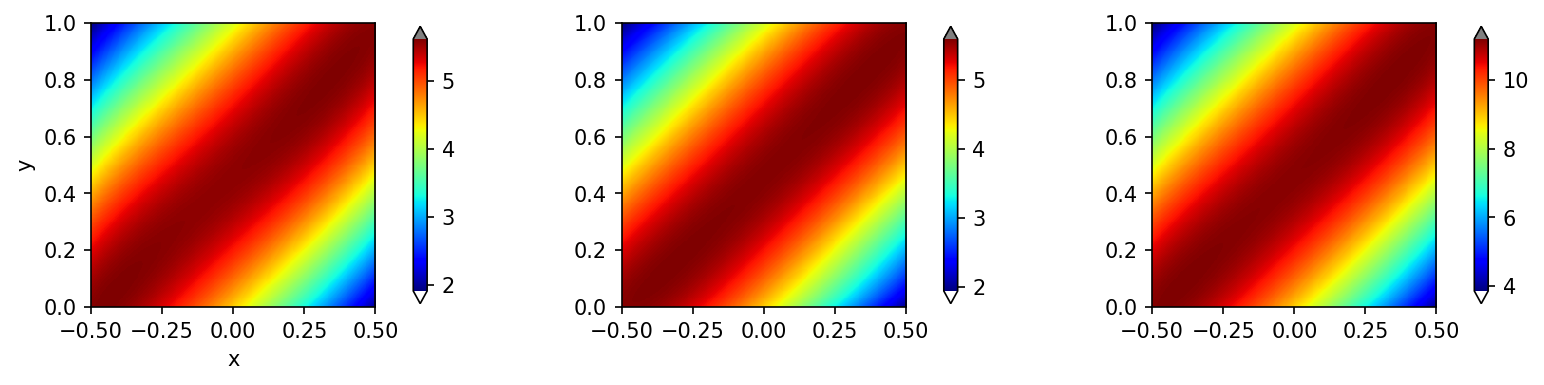

In [423]:
### divergence of the collocation points
#print(np.shape(u_pred))
#from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure(dpi=150)
ax = fig.add_subplot(131)#, projection='3d')
n_points = 300
x = np.linspace(lb[0], ub[0], n_points)
y = np.linspace(lb[1], ub[1], n_points)
X, Y = np.meshgrid(x,y)

UU_star = griddata(nodes, abs(u_xx).flatten(), (X, Y), method='cubic')
sc = ax.imshow(UU_star, interpolation='nearest', cmap='jet', 
                  extent=[nodes[:,0].min(), nodes[:,0].max(), nodes[:,1].min(), nodes[:,1].max()], 
                  origin='lower', aspect='equal')

ax.set(xlabel='x', ylabel='y')

sc.cmap.set_under('white')
sc.cmap.set_over('gray')
plt.colorbar(sc, extend='both', shrink=0.5, pad =0.1)

ax = fig.add_subplot(132)#, projection='3d'
UU_star = griddata(nodes, abs(u_yy).flatten(), (X, Y), method='cubic')
sc = ax.imshow(UU_star, interpolation='nearest', cmap='jet', 
                  extent=[nodes[:,0].min(), nodes[:,0].max(), nodes[:,1].min(), nodes[:,1].max()], 
                  origin='lower', aspect='equal')
#sc = ax.scatter(nodes[:,0], nodes[:,1], c = temperature,s=3, cmap=cm.jet)


sc.cmap.set_under('white')
sc.cmap.set_over('gray')
plt.colorbar(sc, extend='both', shrink=0.5, pad =0.1)

ax = fig.add_subplot(133)#, projection='3d'
UU_star = griddata(nodes, (abs(u_yy) + abs(u_xx)).flatten(), (X, Y), method='cubic')
sc = ax.imshow(UU_star, interpolation='nearest', cmap='jet', 
                  extent=[nodes[:,0].min(), nodes[:,0].max(), nodes[:,1].min(), nodes[:,1].max()], 
                  origin='lower', aspect='equal')
#sc = ax.scatter(nodes[:,0], nodes[:,1], c = temperature,s=3, cmap=cm.jet)


sc.cmap.set_under('white')
sc.cmap.set_over('gray')
plt.colorbar(sc, extend='both', shrink=0.5, pad =0.1)

left  = 0.0  # the left side of the subplots of the figure
right = 1.5    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.3   # the amount of height reserved for white space between subplots

plt.subplots_adjust(left=left, bottom=None, right=right, top=None, wspace=wspace, hspace=hspace)
#ax.set_zlabel('z')
#plt.title('Temperature distribution')
#plt.savefig('Exact.jpg', dpi = 200)

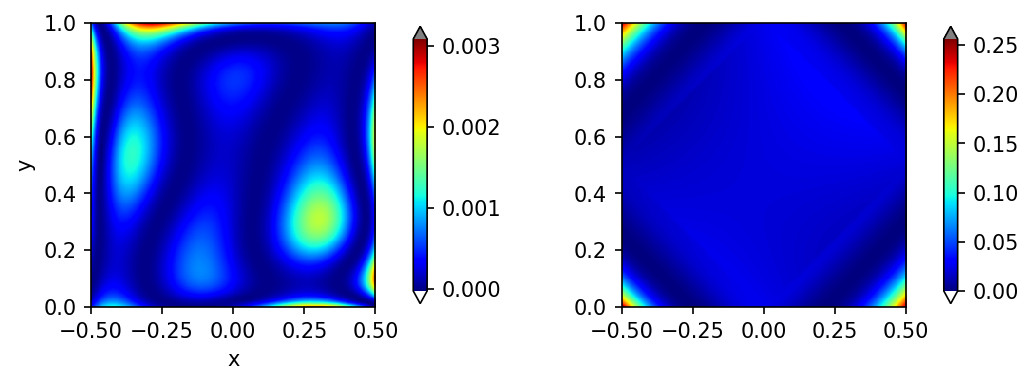

In [424]:
## Pointwise PDE and  BC loss 
#print(np.shape(u_pred))
#from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure(dpi=150)
ax = fig.add_subplot(131)#, projection='3d')
n_points = 300
x = np.linspace(lb[0], ub[0], n_points)
y = np.linspace(lb[1], ub[1], n_points)
X, Y = np.meshgrid(x,y)

UU_star = griddata(nodes, abs(PDE_loss_pointwise).flatten(), (X, Y), method='cubic')
sc = ax.imshow(UU_star, interpolation='nearest', cmap='jet', 
                  extent=[nodes[:,0].min(), nodes[:,0].max(), nodes[:,1].min(), nodes[:,1].max()], 
                  origin='lower', aspect='equal')

ax.set(xlabel='x', ylabel='y')

sc.cmap.set_under('white')
sc.cmap.set_over('gray')
plt.colorbar(sc, extend='both', shrink=0.5, pad =0.1)

ax = fig.add_subplot(132)#, projection='3d'
UU_star = griddata(boundary_nodal_coordinates, abs(BC_loss_pointwise).flatten(), (X, Y), method='cubic')
sc = ax.imshow(UU_star, interpolation='nearest', cmap='jet', 
                  extent=[nodes[:,0].min(), nodes[:,0].max(), nodes[:,1].min(), nodes[:,1].max()], 
                  origin='lower', aspect='equal')
#sc = ax.scatter(nodes[:,0], nodes[:,1], c = temperature,s=3, cmap=cm.jet)


sc.cmap.set_under('white')
sc.cmap.set_over('gray')
plt.colorbar(sc, extend='both', shrink=0.5, pad =0.1)

# ax = fig.add_subplot(133)#, projection='3d'
# UU_star = griddata(nodes, (abs(u_yy) + abs(u_xx)).flatten(), (X, Y), method='cubic')
# sc = ax.imshow(UU_star, interpolation='nearest', cmap='jet', 
#                   extent=[nodes[:,0].min(), nodes[:,0].max(), nodes[:,1].min(), nodes[:,1].max()], 
#                   origin='lower', aspect='equal')
# #sc = ax.scatter(nodes[:,0], nodes[:,1], c = temperature,s=3, cmap=cm.jet)


# sc.cmap.set_under('white')
# sc.cmap.set_over('gray')
# plt.colorbar(sc, extend='both', shrink=0.5, pad =0.1)

left  = 0.0  # the left side of the subplots of the figure
right = 1.5    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.3   # the amount of height reserved for white space between subplots

plt.subplots_adjust(left=left, bottom=None, right=right, top=None, wspace=wspace, hspace=hspace)
#ax.set_zlabel('z')
#plt.title('Temperature distribution')
#plt.savefig('Exact.jpg', dpi = 200)

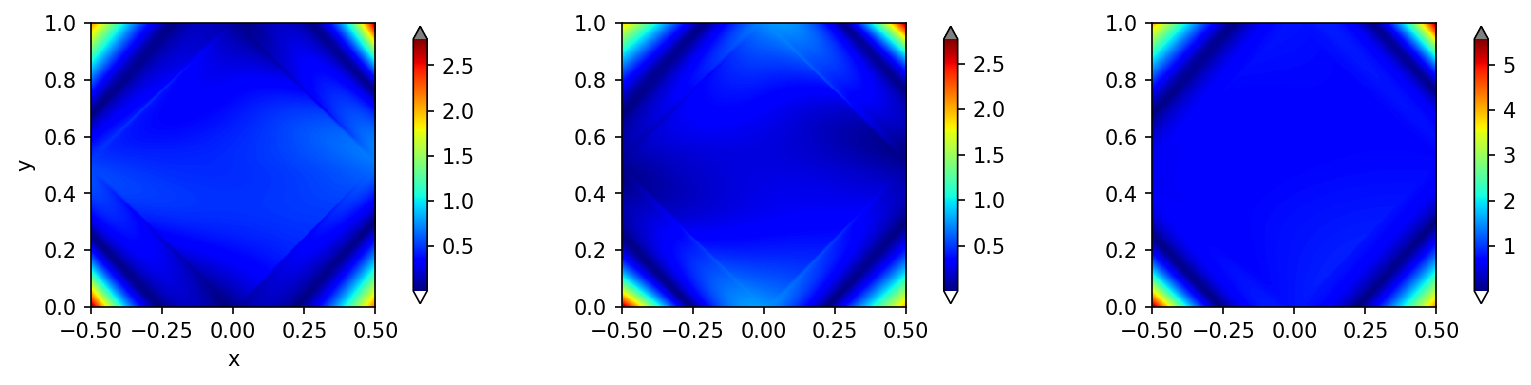

In [425]:
# Pointwise derivative of the BC loss 
#print(np.shape(u_pred))
#from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure(dpi=150)
ax = fig.add_subplot(131)#, projection='3d')
n_points = 300
x = np.linspace(lb[0], ub[0], n_points)
y = np.linspace(lb[1], ub[1], n_points)
X, Y = np.meshgrid(x,y)

UU_star = griddata(boundary_nodal_coordinates, abs(L_x_BC).flatten(), (X, Y), method='cubic')
sc = ax.imshow(UU_star, interpolation='nearest', cmap='jet', 
                  extent=[nodes[:,0].min(), nodes[:,0].max(), nodes[:,1].min(), nodes[:,1].max()], 
                  origin='lower', aspect='equal')

ax.set(xlabel='x', ylabel='y')

sc.cmap.set_under('white')
sc.cmap.set_over('gray')
plt.colorbar(sc, extend='both', shrink=0.5, pad =0.1)

ax = fig.add_subplot(132)#, projection='3d'
UU_star = griddata(boundary_nodal_coordinates, abs(L_y_BC).flatten(), (X, Y), method='cubic')
sc = ax.imshow(UU_star, interpolation='nearest', cmap='jet', 
                  extent=[nodes[:,0].min(), nodes[:,0].max(), nodes[:,1].min(), nodes[:,1].max()], 
                  origin='lower', aspect='equal')
#sc = ax.scatter(nodes[:,0], nodes[:,1], c = temperature,s=3, cmap=cm.jet)


sc.cmap.set_under('white')
sc.cmap.set_over('gray')
plt.colorbar(sc, extend='both', shrink=0.5, pad =0.1)

ax = fig.add_subplot(133)#, projection='3d'
UU_star = griddata(boundary_nodal_coordinates, (abs(L_x_BC) + abs(L_y_BC)).flatten(), (X, Y), method='cubic')
sc = ax.imshow(UU_star, interpolation='nearest', cmap='jet', 
                  extent=[nodes[:,0].min(), nodes[:,0].max(), nodes[:,1].min(), nodes[:,1].max()], 
                  origin='lower', aspect='equal')
#sc = ax.scatter(nodes[:,0], nodes[:,1], c = temperature,s=3, cmap=cm.jet)


sc.cmap.set_under('white')
sc.cmap.set_over('gray')
plt.colorbar(sc, extend='both', shrink=0.5, pad =0.1)

left  = 0.0  # the left side of the subplots of the figure
right = 1.5    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.3   # the amount of height reserved for white space between subplots

plt.subplots_adjust(left=left, bottom=None, right=right, top=None, wspace=wspace, hspace=hspace)
#ax.set_zlabel('z')
#plt.title('Temperature distribution')
#plt.savefig('Exact.jpg', dpi = 200)

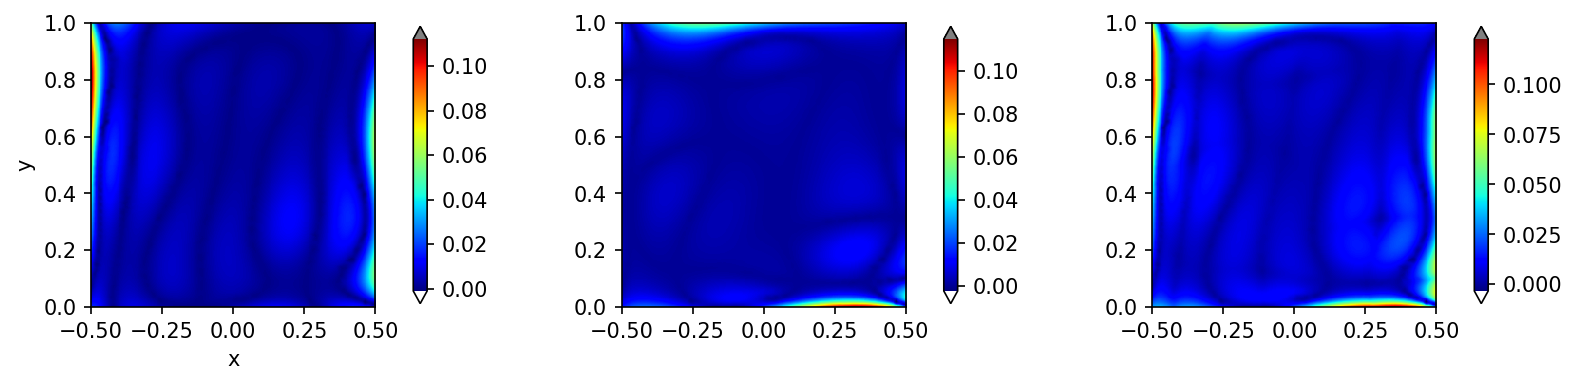

In [426]:
# Pointwise derivative of the PDE loss 
#print(np.shape(u_pred))
#from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure(dpi=150)
ax = fig.add_subplot(131)#, projection='3d')
n_points = 300
x = np.linspace(lb[0], ub[0], n_points)
y = np.linspace(lb[1], ub[1], n_points)
X, Y = np.meshgrid(x,y)

UU_star = griddata(nodes, abs(L_x).flatten(), (X, Y), method='cubic')
sc = ax.imshow(UU_star, interpolation='nearest', cmap='jet', 
                  extent=[nodes[:,0].min(), nodes[:,0].max(), nodes[:,1].min(), nodes[:,1].max()], 
                  origin='lower', aspect='equal')

ax.set(xlabel='x', ylabel='y')

sc.cmap.set_under('white')
sc.cmap.set_over('gray')
plt.colorbar(sc, extend='both', shrink=0.5, pad =0.1)

ax = fig.add_subplot(132)#, projection='3d'
UU_star = griddata(nodes, abs(L_y).flatten(), (X, Y), method='cubic')
sc = ax.imshow(UU_star, interpolation='nearest', cmap='jet', 
                  extent=[nodes[:,0].min(), nodes[:,0].max(), nodes[:,1].min(), nodes[:,1].max()], 
                  origin='lower', aspect='equal')
#sc = ax.scatter(nodes[:,0], nodes[:,1], c = temperature,s=3, cmap=cm.jet)


sc.cmap.set_under('white')
sc.cmap.set_over('gray')
plt.colorbar(sc, extend='both', shrink=0.5, pad =0.1)

ax = fig.add_subplot(133)#, projection='3d'
UU_star = griddata(nodes, (abs(L_x) + abs(L_y)).flatten(), (X, Y), method='cubic')
sc = ax.imshow(UU_star, interpolation='nearest', cmap='jet', 
                  extent=[nodes[:,0].min(), nodes[:,0].max(), nodes[:,1].min(), nodes[:,1].max()], 
                  origin='lower', aspect='equal')
#sc = ax.scatter(nodes[:,0], nodes[:,1], c = temperature,s=3, cmap=cm.jet)


sc.cmap.set_under('white')
sc.cmap.set_over('gray')
plt.colorbar(sc, extend='both', shrink=0.5, pad =0.1)

left  = 0.0  # the left side of the subplots of the figure
right = 1.5    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.3   # the amount of height reserved for white space between subplots

plt.subplots_adjust(left=left, bottom=None, right=right, top=None, wspace=wspace, hspace=hspace)
#ax.set_zlabel('z')
#plt.title('Temperature distribution')
#plt.savefig('Exact.jpg', dpi = 200)

(0.0, 1.0450062900781631)

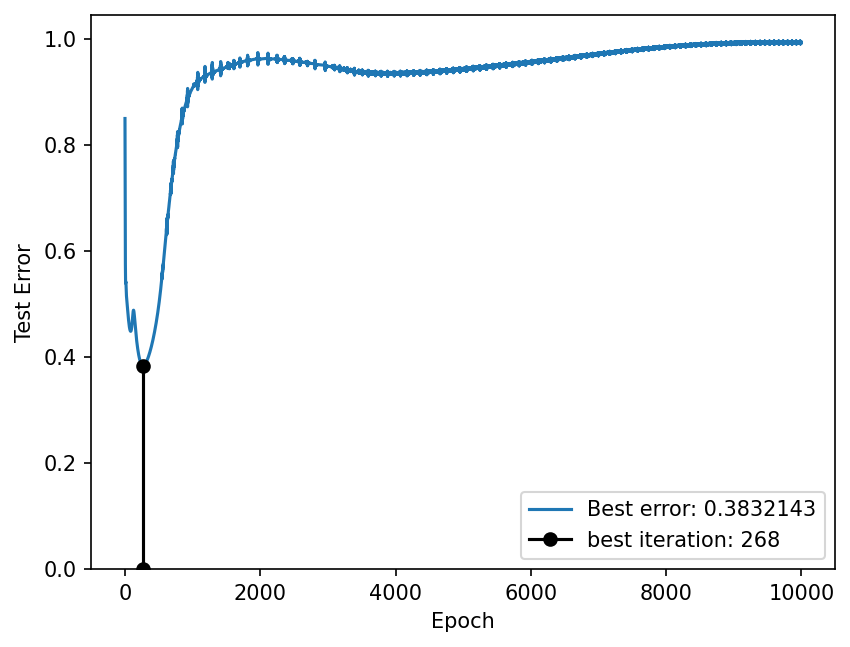

In [320]:
# Plot test error
#plt.figure(1,figsize=(8, 8), dpi=80)
plt.figure(1,dpi=150)
iter_array = np.arange(0,max_iter)
plt.plot(iter_array,test_error_array)
plt.plot([best_iter,best_iter],[0,best_error_vec],'o-k')
plt.xlabel('Epoch')
plt.ylabel('Test Error')
plt.legend(['Best error: ' +str(best_error_vec),'best iteration: '+str(best_iter)])
plt.ylim(bottom=0)  # https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.ylim.html
#plt.savefig('plots/Test_error_iteration.jpg',dpi=150)

In [ ]:
# Detach loss tensors
#print(np.shape(total_loss_array))
#print(total_loss_array)
#print(BC_loss_array)
#print(PDE_loss_array)
#print(np.array_equal(PDE_loss_array,BC_loss_array))

Text(0, 0.5, 'Loss')

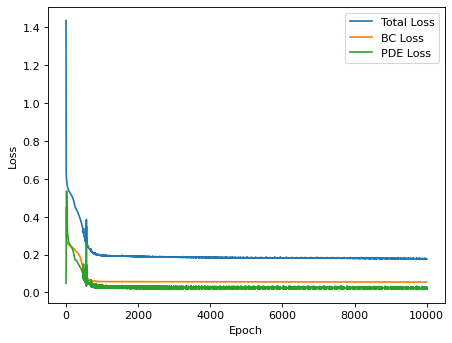

In [308]:
plt.figure(2, dpi=80)

iter_array = np.arange(0,max_iter)
plt.plot(iter_array,total_loss_array)
plt.plot(iter_array,BC_loss_array)
plt.plot(iter_array, PDE_loss_array)
plt.legend(['Total Loss','BC Loss','PDE Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.savefig('plots/loss_iteration.jpg',dpi=150)

In [ ]:
# For plotting nicer plot we use plt.imshow().
# First we convert the unstructured data to mesh grid then use plt.imshow()

Text(0, 0.5, 'y')

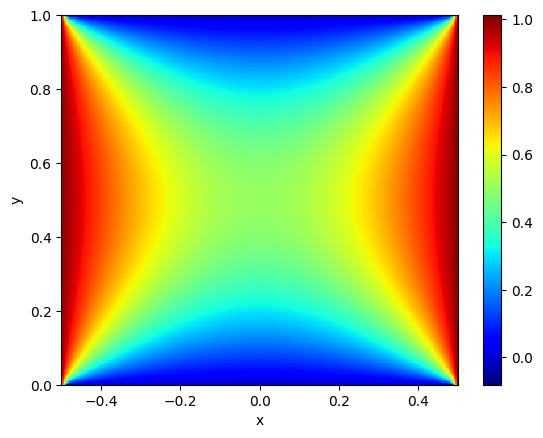

In [212]:
#print(np.shape(u_pred))
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)#, projection='3d')
n_points = 300
x = np.linspace(lb[0], ub[0], n_points)
y = np.linspace(lb[1], ub[1], n_points)
X, Y = np.meshgrid(x,y)

UU_star = griddata(nodes, temperature.flatten(), (X, Y), method='cubic')
sc = ax.imshow(UU_star, interpolation='nearest', cmap='jet', 
                  extent=[nodes[:,0].min(), nodes[:,0].max(), nodes[:,1].min(), nodes[:,1].max()], 
                  origin='lower', aspect='auto')

#sc = ax.scatter(nodes[:,0], nodes[:,1], c = temperature,s=3, cmap=cm.jet)
plt.colorbar(sc)
plt.xlabel('x')
plt.ylabel('y')
#ax.set_zlabel('z')
#plt.title('Temperature distribution')
#plt.savefig('Exact.jpg', dpi = 200)

Text(0, 0.5, 'y')

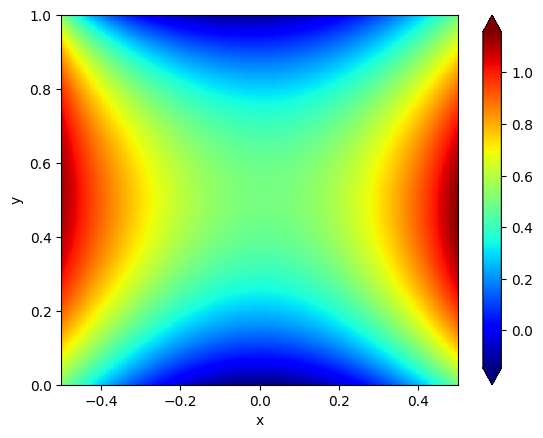

In [366]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)#, projection='3d')
n_points = 300
x = np.linspace(lb[0], ub[0], n_points)
y = np.linspace(lb[1], ub[1], n_points)
X, Y = np.meshgrid(x,y)

UU_star = griddata(nodes, best_u_pred.flatten(), (X, Y), method='cubic')
sc = ax.imshow(UU_star, interpolation='nearest', cmap='jet', 
                  extent=[nodes[:,0].min(), nodes[:,0].max(), nodes[:,1].min(), nodes[:,1].max()], 
                  origin='lower', aspect='auto')
#ax = fig.add_subplot(111)#, projection='3d')
#sc = ax.scatter(nodes[:,0], nodes[:,1], c = best_u_pred, cmap=cm.jet, vmin=0, vmax=1)
plt.colorbar(sc, extend='both')
sc.cmap.set_under('k')
sc.cmap.set_over('k')
plt.xlabel('x')
plt.ylabel('y')
#ax.set_zlabel('z')
#plt.title('Temperature distribution')
#plt.savefig('Iteration_'+str(max_iter)+'_PINN_predicted.jpg', dpi = 200)

Text(0, 0.5, 'y')

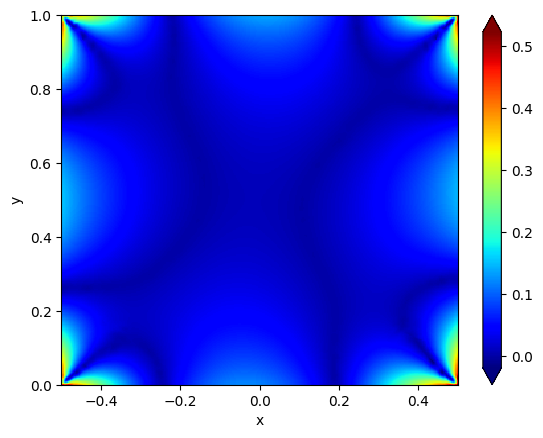

In [141]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)#, projection='3d')
n_points = 300
x = np.linspace(lb[0], ub[0], n_points)
y = np.linspace(lb[1], ub[1], n_points)
X, Y = np.meshgrid(x,y)

UU_star = griddata(nodes, abs(best_u_pred-temperature).flatten(), (X, Y), method='cubic')
sc = ax.imshow(UU_star, interpolation='nearest', cmap='jet', 
                  extent=[nodes[:,0].min(), nodes[:,0].max(), nodes[:,1].min(), nodes[:,1].max()], 
                  origin='lower', aspect='auto')
#ax = fig.add_subplot(111)#, projection='3d')
#sc = ax.scatter(nodes[:,0], nodes[:,1], c = best_u_pred, cmap=cm.jet, vmin=0, vmax=1)
plt.colorbar(sc, extend='both')
sc.cmap.set_under('k')
sc.cmap.set_over('k')
plt.xlabel('x')
plt.ylabel('y')